In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature

from nansat import Nansat, Domain, NSR

from sea_ice_drift.lib import get_spatial_mean, get_uint8_image
from sea_ice_drift.ftlib import feature_tracking
from sea_ice_drift.pmlib import pattern_matching
from sea_ice_drift.libdefor import get_deformation_nodes

import csv

%matplotlib inline

In [2]:
from osgeo import gdal
from osgeo import osr

In [ ]:
r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'
r'/home/jovyan/data/SAR_images/subset_of_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV.tif'
r'/home/jovyan/data/SAR_images_forecast/Forecasted_20221119T08_subset_of_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV.tif'

In [3]:
# Download arrays
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200123T120618.npy
#!wget https://github.com/nansencenter/sea_ice_drift_test_files/raw/master/S1B_EW_GRDM_1SDH_20200125T114955.npy
f1 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV_Cnv.tif")
f2 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/subset_S1A_EW_GRDM_1SDH_20221120T080155_20221120T080259_045975_05805E_51E1_Orb_Cal_TC_HV_Cnv.tif")
f3 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/Hourly_aligned_ens8_20221120T09_subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV_Cnv.tif")
f4 = gdal.Open("/home/jovyan/work/icedrift/Special_curriculum/19-20_subset_experiment/SAR/Hourly_aligned_ens6_20221120T09_subset_S1A_EW_GRDM_1SDH_20221119T072104_20221119T072208_045960_057FE5_E8B1_Orb_Cal_TC_HV_Cnv.tif")

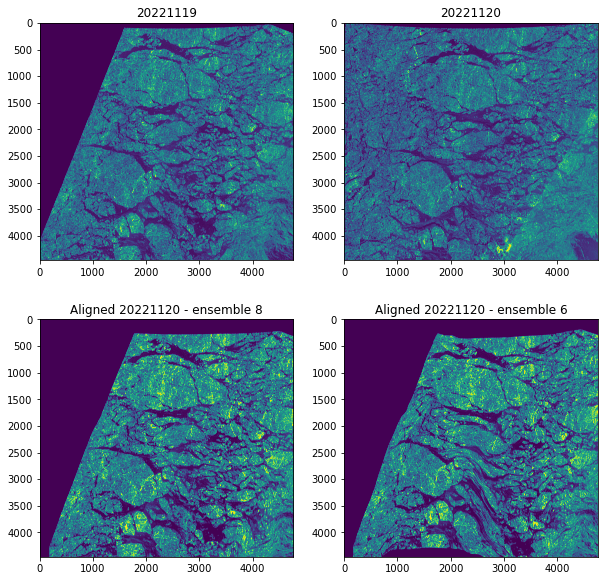

In [4]:
# load example ar2rays
a1 = f1.ReadAsArray() 
a2 = f2.ReadAsArray()
a3 = f3.ReadAsArray()
a4 = f4.ReadAsArray()

fig, ax = plt.subplots(2,2, figsize=(10,10))

im0 = ax[0,0].imshow(a1)
im1 = ax[0,1].imshow(a2)
im2 = ax[1,0].imshow(a3)
im3 = ax[1,1].imshow(a4)

ax[0,0].set_title("20221119")
ax[0,1].set_title("20221120")
ax[1,0].set_title("Aligned 20221120 - ensemble 8")
ax[1,1].set_title("Aligned 20221120 - ensemble 6")

plt.show()



In [5]:
# Create two Nansat objects with original tiff georeference imported from gdal object.
# The same georefercne will be use for retrieval of drift.

srs = f1.GetSpatialRef() 

rows, cols = a1.shape
d = Domain(srs, ds=f1)
n1 = Nansat.from_domain(d, a1)
n2 = Nansat.from_domain(d, a2)
n3 = Nansat.from_domain(d, a3)
n4 = Nansat.from_domain(d, a4)

In [34]:
print("srs - s", srs)
print(" d - ", d)

srs - s PROJCS["WGS 84 / IBCAO Polar Stereographic",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563,
                AUTHORITY["EPSG","7030"]],
            AUTHORITY["EPSG","6326"]],
        PRIMEM["Greenwich",0,
            AUTHORITY["EPSG","8901"]],
        UNIT["degree",0.0174532925199433,
            AUTHORITY["EPSG","9122"]],
        AUTHORITY["EPSG","4326"]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",75],
    PARAMETER["central_meridian",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1,
        AUTHORITY["EPSG","9001"]],
    AXIS["Easting",SOUTH],
    AXIS["Northing",SOUTH],
    AUTHORITY["EPSG","3996"]]
 d -  Domain:[4766 x 4460]
----------------------------------------
Projection(dataset):
PROJCS["WGS 84 / IBCAO Polar Stereographic",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563]],
        PRIMEM["Gre

In [23]:
d

Domain:[4766 x 4460]
----------------------------------------
Projection(dataset):
PROJCS["WGS 84 / IBCAO Polar Stereographic",
    GEOGCS["WGS 84",
        DATUM["WGS_1984",
            SPHEROID["WGS 84",6378137,298.257223563]],
        PRIMEM["Greenwich",0],
        UNIT["degree",0.0174532925199433]],
    PROJECTION["Polar_Stereographic"],
    PARAMETER["latitude_of_origin",75],
    PARAMETER["central_meridian",0],
    PARAMETER["false_easting",0],
    PARAMETER["false_northing",0],
    UNIT["metre",1]]
----------------------------------------
Corners (lon, lat):
	 ( -7.52,  81.56)  (  4.30,  81.61)
	 ( -6.31,  79.95)  (  3.60,  79.99)

In [6]:
# Close the dataset
f1 = None
f2 = None
f3 = None
f4 = None

In [7]:
# Run Feature Tracking between SAR1 and SAR2 
# get start/end coordinates in the image coordinate system (colums/rows)  
c1, r1, c2, r2 = feature_tracking(n1, n2, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.2977237701416016
Ratio test 0.600000 found 352 keypoints
MaxDrift filter: 352 -> 352
LSTSQ filter: 352 -> 352


In [8]:
# Run Feature Tracking between SAR2 and SARprediction ens 8 (error estimation)
# get start/end coordinates in the image coordinate system (colums/rows)  
c1_er_1, r1_er_1, c2_er_1, r2_er_1 = feature_tracking(n2, n3, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.2055928707122803
Ratio test 0.600000 found 141 keypoints
MaxDrift filter: 141 -> 141
LSTSQ filter: 141 -> 141


In [9]:
# Run Feature Tracking between SAR2 and SARprediction ens 6 (error estimation)
# get start/end coordinates in the image coordinate system (colums/rows)  
c1_er_2, r1_er_2, c2_er_2, r2_er_2 = feature_tracking(n2, n4, nFeatures=20000, ratio_test=0.6, max_drift=100000, verbose=True)

Key points found: 20000
Key points found: 20000
Domain filter: 20000 -> 20000
Domain filter: 20000 -> 20000
Keypoints matched 1.040867805480957
Ratio test 0.600000 found 93 keypoints
MaxDrift filter: 93 -> 93
LSTSQ filter: 93 -> 82


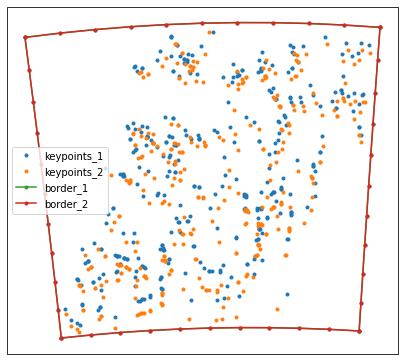

In [10]:
# Plot identified and matched keypoints in geographic coordinates for SAR1 and SAR2 

# convert row/column coordinates of matched features to lon/lat
lon1ft, lat1ft = n1.transform_points(c1, r1)
lon2ft, lat2ft = n2.transform_points(c2, r2)

# get lon/lat coordinates of the border of images
lon1b, lat1b = n1.get_border()
lon2b, lat2b = n2.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft, lat1ft, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft, lat2ft, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b, lat1b, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b, lat2b, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

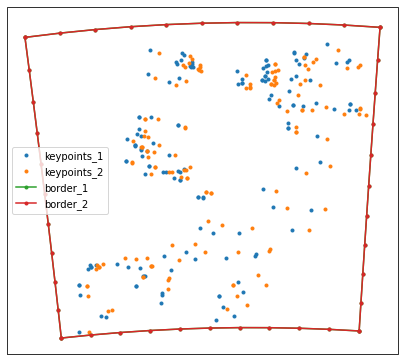

In [11]:
# Plot identified and matched keypoints in geographic coordinates for SAR2 and SARprediction ens8

# convert row/column coordinates of matched features to lon/lat
lon1ft_er_1, lat1ft_er_1 = n2.transform_points(c1_er_1, r1_er_1)
lon2ft_er_1, lat2ft_er_1 = n3.transform_points(c2_er_1, r2_er_1)

# get lon/lat coordinates of the border of images
lon1b_er_1, lat1b_er_1 = n2.get_border()
lon2b_er_1, lat2b_er_1 = n3.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft_er_1, lat1ft_er_1, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft_er_1, lat2ft_er_1, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b_er_1, lat1b_er_1, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b_er_1, lat2b_er_1, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

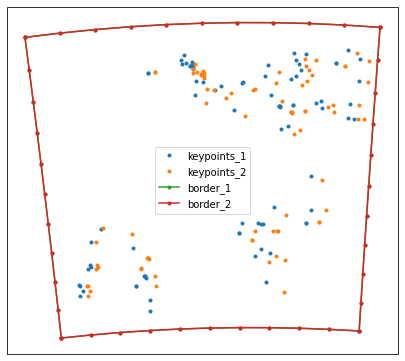

In [12]:
# Plot identified and matched keypoints in geographic coordinates for SAR2 and SARprediction ens6

# convert row/column coordinates of matched features to lon/lat
lon1ft_er_2, lat1ft_er_2 = n2.transform_points(c1_er_2, r1_er_2)
lon2ft_er_2, lat2ft_er_2 = n3.transform_points(c2_er_2, r2_er_2)

# get lon/lat coordinates of the border of images
lon1b_er_2, lat1b_er_2 = n2.get_border()
lon2b_er_2, lat2b_er_2 = n3.get_border()


# get hi-res landmask
land_50m = cfeature.NaturalEarthFeature('physical', 'land', '50m',
                                        edgecolor='face',
                                        facecolor=cfeature.COLORS['land'])

plt.figure(figsize=(7,7))
ax = plt.axes(projection=ccrs.Mercator())
ax.add_feature(land_50m, zorder=0, edgecolor='black')
ax.plot(lon1ft_er_2, lat1ft_er_2, '.', label='keypoints_1', transform=ccrs.PlateCarree())
ax.plot(lon2ft_er_2, lat2ft_er_2, '.', label='keypoints_2', transform=ccrs.PlateCarree())
ax.plot(lon1b_er_2, lat1b_er_2, '.-', label='border_1', transform=ccrs.PlateCarree())
ax.plot(lon2b_er_2, lat2b_er_2, '.-', label='border_2', transform=ccrs.PlateCarree())
ax.legend()
plt.show()

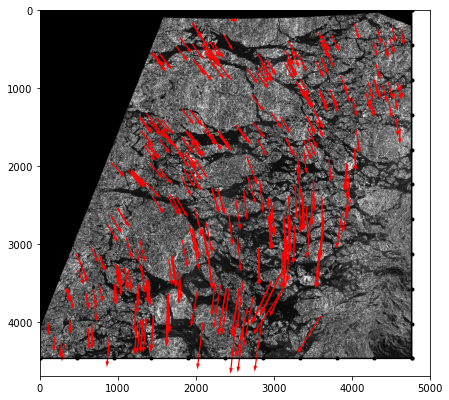

In [13]:
# Plot ice drift on top of image_1 for SAR1 and SAR2 

# end points in image_1 coordinate system
n1c2, n1r2 = n1.transform_points(lon2ft, lat2ft, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr = n1r2 - r1
dc = n1c2 - c1

# border of image_2 in image_1 coordinate system
n1lon2b, n1lat2b = n1.transform_points(lon2b, lat2b, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n1[1], cmap='gray')
plt.quiver(c1, r1, dc, dr, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b, n1lat2b, 'k.-')
plt.show()

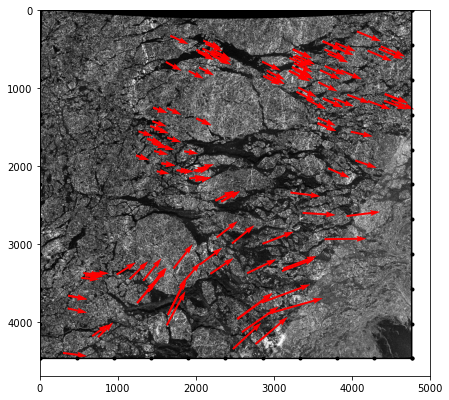

In [14]:
# Plot ice drift on top of image_1 for SAR2 and SAR2_prediction ens8

# end points in image_1 coordinate system
n1c2_er_1, n1r2_er_1 = n2.transform_points(lon2ft_er_1, lat2ft_er_1, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr_er_1 = n1r2_er_1 - r1_er_1
dc_er_1 = n1c2_er_1 - c1_er_1

# border of image_2 in image_1 coordinate system
n1lon2b_er_1, n1lat2b_er_1 = n2.transform_points(lon2b_er_1, lat2b_er_1, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n2[1], cmap='gray')
plt.quiver(c1_er_1, r1_er_1, dc_er_1, dr_er_1, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b_er_1, n1lat2b_er_1, 'k.-')
plt.show()

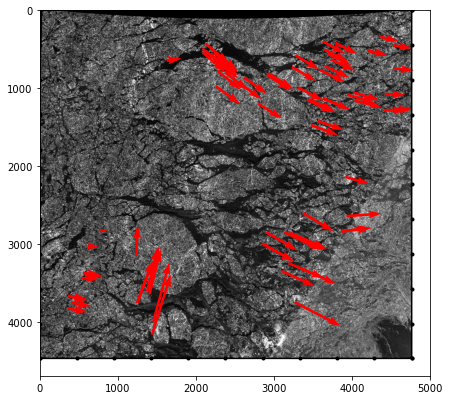

In [15]:
# Plot ice drift on top of image_1 for SAR2 and SAR2_prediction ens6

# end points in image_1 coordinate system
n1c2_er_2, n1r2_er_2 = n2.transform_points(lon2ft_er_2, lat2ft_er_2, DstToSrc=1)

# ice drift components in image_1 coordinate system
dr_er_2 = n1r2_er_2 - r1_er_2
dc_er_2 = n1c2_er_2 - c1_er_2

# border of image_2 in image_1 coordinate system
n1lon2b_er_2, n1lat2b_er_2 = n2.transform_points(lon2b_er_2, lat2b_er_2, DstToSrc=1)

# plot of ice drift. Arrows are 5 times longer than actual drift
plt.figure(figsize=(7,7))
plt.imshow(n2[1], cmap='gray')
plt.quiver(c1_er_2, r1_er_2, dc_er_2, dr_er_2, color='r', angles='xy', scale_units='xy', scale=0.5)
plt.plot(n1lon2b_er_2, n1lat2b_er_2, 'k.-')
plt.show()

Ask Anton how to create this domain based on the projection from gdal object or just previous domain d but use worse resolution 2,5 km? Figure out the difference betweeen domains

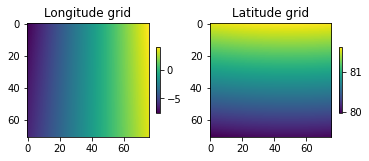

In [16]:
# Create lon/lat grids in Polar stereographic coordinate system 
# Extent of the grid roughly corresponds to the extent of the image_1

# projection (https://epsg.io/3413) or 3996
srs = NSR(3996)

# projected coordinates of the first image corners
rows, cols = n1.shape()
n1x, n1y = n1.transform_points([0,cols,cols,0], [0,0,rows,rows], dst_srs=srs)

# domain of interest with resolution 5000 (or 2500) m
dom_pm = Domain(srs, f'-te {n1x.min()} {n1y.min()} {n1x.max()} {n1y.max()} -tr 2500 2500')


# lon/lat grids in polar stereographic projection covering image_1
lon1pm, lat1pm = dom_pm.get_geolocation_grids()
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()

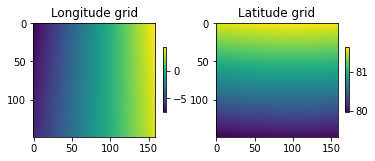

In [30]:
'''
# Create lon/lat grids 

# lon/lat grids in polar stereographic projection covering image_1
pm_step = 30 # lon/lat grids are subsampled
lon1pm, lat1pm = d.get_geolocation_grids(pm_step)
plt.subplot(1,2,1);plt.imshow(lon1pm);plt.colorbar(shrink=0.3);plt.title('Longitude grid')
plt.subplot(1,2,2);plt.imshow(lat1pm);plt.colorbar(shrink=0.3);plt.title('Latitude grid')
plt.show()
'''

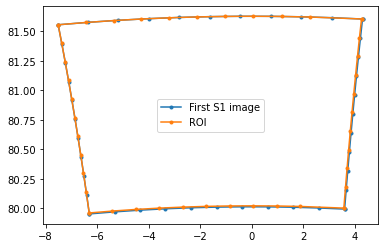

In [17]:
# plot coverage of the first S1 image and ROI
plt.plot(*n1.get_border(), '.-', label='First S1 image')
plt.plot(*dom_pm.get_border(), '.-', label='ROI')
plt.legend()
plt.show()

In [18]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm, vpm, apm, rpm, hpm, lon2pm, lat2pm = pattern_matching(lon1pm, lat1pm, n1, c1, r1, n2, c2, r2,
                                                          srs=srs.ExportToProj4())

100% 01000.0 04188.0 00979.0 04379.0 -03.0 0.72 13.10
 Pattern matching - OK! (  5 sec)


In [19]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix for SAR2 and SAR2_prediction  ens8
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm_er_1, vpm_er_1, apm_er_1, rpm_er_1, hpm_er_1, lon2pm_er_1, lat2pm_er_1 = pattern_matching(lon1pm, lat1pm, n2, c1_er_1, r1_er_1, n3, c2_er_1, r2_er_1,
                                                          srs=srs.ExportToProj4())

20% 04188.0 00875.0 04332.0 00930.0 +00.0 0.58 7.7410% 04438.0 00438.0 04595.0 00501.0 +00.0 0.61 8.53

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


94% 03500.0 04125.0 03690.0 04017.0 -03.0 0.43 0.777
 Pattern matching - OK! (  5 sec)


In [20]:
# Run Pattern Matching for each element in lon1pm/lat1pm matrix for SAR2 and SAR2_prediction ens6
# ice displacement upm and vpm are returned in meters in Mercator (faked) projection
upm_er_2, vpm_er_2, apm_er_2, rpm_er_2, hpm_er_2, lon2pm_er_2, lat2pm_er_2 = pattern_matching(lon1pm, lat1pm, n2, c1_er_2, r1_er_2, n4, c2_er_2, r2_er_2,
                                                          srs=srs.ExportToProj4())

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


20% 04063.0 00875.0 04219.0 00915.0 +03.0 0.67 3.37300% 00062.0 00063.0 00071.0 00101.0 -03.0 0.00 0nan

/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide
/opt/conda/lib/python3.10/site-packages/sea_ice_drift-0.7.1-py3.10.egg/sea_ice_drift/pmlib.py:57: RuntimeWarning: invalid value encountered in true_divide


94% 03750.0 04125.0 03947.0 04069.0 +03.0 0.47 7.6108% 02312.0 00813.0 02459.0 00929.0 +00.0 0.71 7.9814% 03313.0 00625.0 03469.0 00712.0 +03.0 0.87 6.9346% 00187.0 02063.0 00220.0 02003.0 -03.0 0.00 0nan32% 01062.0 01438.0 01112.0 01418.0 -03.0 0.00 0nan50% 03813.0 02188.0 03980.0 02247.0 +03.0 0.47 9.0634% 02812.0 01500.0 02929.0 01585.0 +00.0 0.47 2.4080% 04375.0 03500.0 04595.0 03502.0 +00.0 0.37 8.2974% 03375.0 03250.0 03600.0 03342.0 +03.0 0.78 5.83
 Pattern matching - OK! (  6 sec)


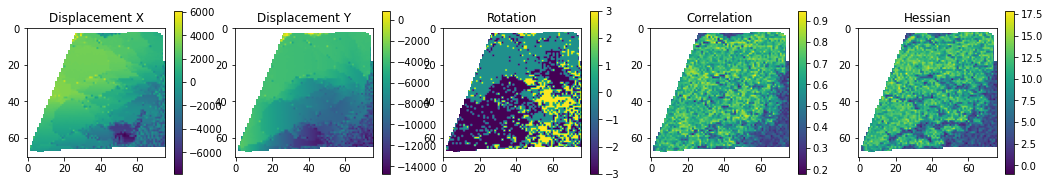

In [21]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm, vpm, apm, rpm, hpm]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

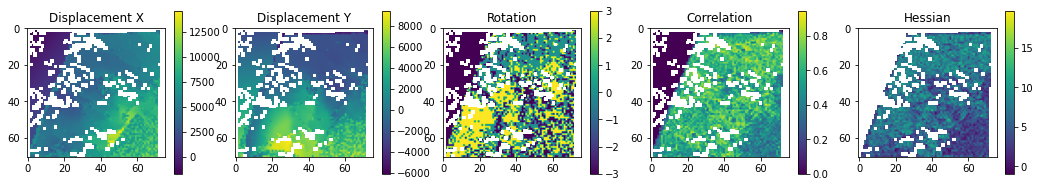

In [22]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm_er_1, vpm_er_1, apm_er_1, rpm_er_1, hpm_er_1]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

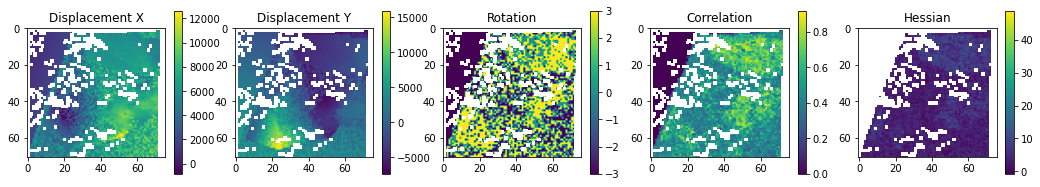

In [23]:
# plot retrieved matrices
titles = ['Displacement X', 'Displacement Y', 'Rotation', 'Correlation', 'Hessian']
fig, ax = plt.subplots(1,5, figsize=(18,3))
for i, a in enumerate([upm_er_2, vpm_er_2, apm_er_2, rpm_er_2, hpm_er_2]):
    ax[i].set_title(titles[i])
    im = ax[i].imshow(a)
    plt.colorbar(im, ax=ax[i])

plt.show()

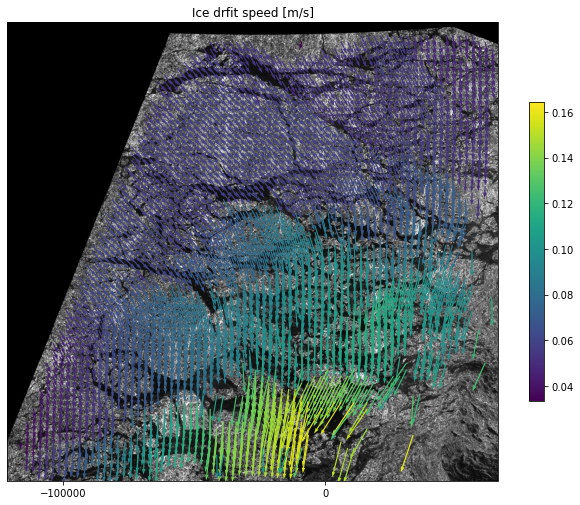

In [24]:
dayssec = 24*60*60

# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u = upm / delta_t
v = vpm / delta_t
speed = np.sqrt((v**2+u**2)) 

# plot valid vectors in Polar stereographic projection
gpi = (hpm > 7) 
# X/Y grids in polar stereographic projection covering image_1
x1pm, y1pm = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm, y1pm = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
quiv=ax.quiver(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi],speed[gpi], scale=2) #cmap='jet', width=0.008
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

In [25]:
# compute deformation components [1/s], area [m2], perimeter [m], triangulation
e1, e2, e3, a, p, t = get_deformation_nodes(x1pm[gpi], y1pm[gpi], u[gpi], v[gpi])
# create mask for invalid elements (too squeezed or too large)
mask = (np.sqrt(a)/p < 0.15) + (a > 0.1e8)

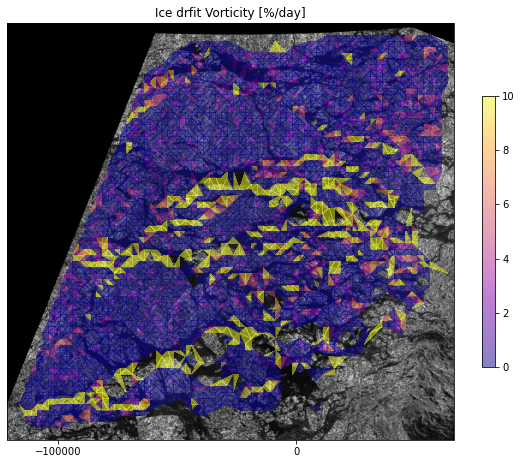

In [26]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
trp = plt.tripcolor(x1pm[gpi], y1pm[gpi], e1*24*60*60*100, triangles=t, vmin=0, vmax=10, cmap='plasma', mask=mask, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Vorticity [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

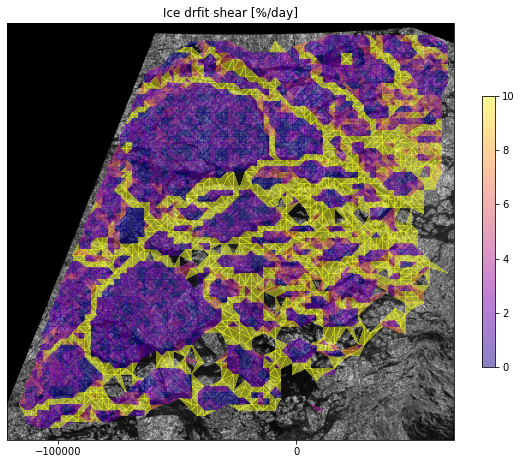

In [27]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
trp = plt.tripcolor(x1pm[gpi], y1pm[gpi], e2*24*60*60*100, triangles=t, vmin=0, vmax=10, cmap='plasma', mask=mask, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit shear [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

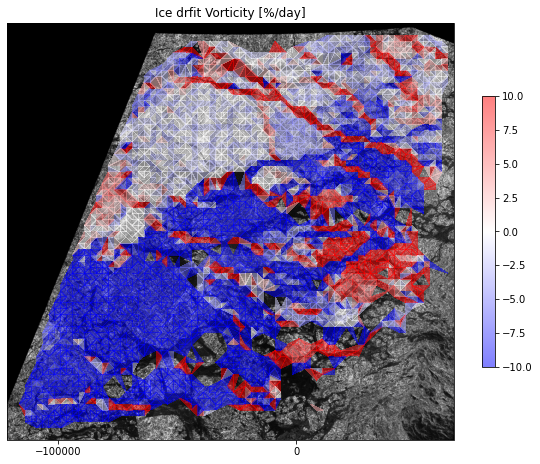

In [28]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a1, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
trp = plt.tripcolor(x1pm[gpi], y1pm[gpi], e3*24*60*60*100, triangles=t, vmin=-10, vmax=10, cmap='bwr', mask=mask, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Vorticity [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
plt.show()

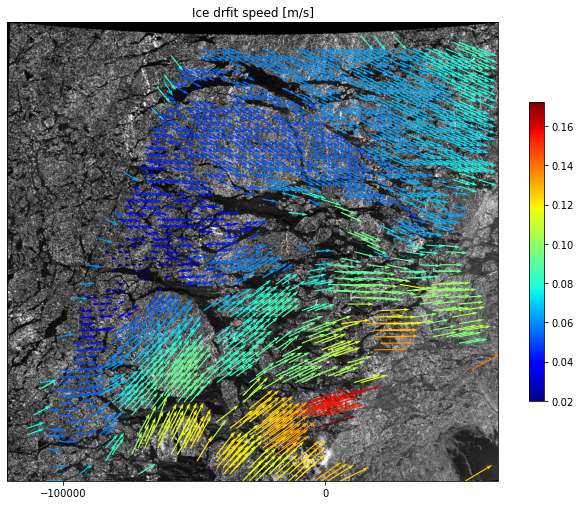

In [29]:
# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u_er_1 = upm_er_1 / delta_t
v_er_1 = vpm_er_1 / delta_t
speed_er_1 = np.sqrt((v_er_1**2+u_er_1**2)) 

# plot valid vectors in Polar stereographic projection
gpi_er = (hpm_er_1 > 7) 
# X/Y grids in polar stereographic projection covering image_1
x1pm_er, y1pm_er = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm_er, y1pm_er = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
quiv=ax.quiver(x1pm_er[gpi_er], y1pm_er[gpi_er], u_er_1[gpi_er], v_er_1[gpi_er],speed_er_1[gpi_er], scale=2, cmap='jet') #cmap='jet', width=0.008
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

In [32]:
# compute deformation components [1/s], area [m2], perimeter [m], triangulation
e1_er_1, e2_er_1, e3_er_1, a_er_1, p_er_1, t_er_1 = get_deformation_nodes(x1pm_er[gpi_er], y1pm_er[gpi_er], u_er_1[gpi_er], v_er_1[gpi_er])
# create mask for invalid elements (too squeezed or too large)
mask_er = (np.sqrt(a_er_1)/p_er_1 < 0.15) + (a_er_1 > 1e8)

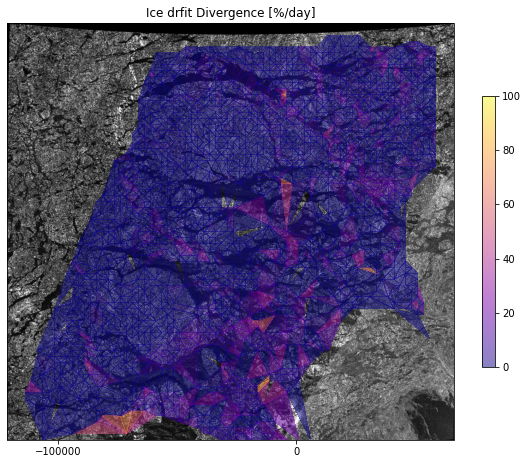

In [34]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
trp = plt.tripcolor(x1pm_er[gpi_er], y1pm_er[gpi_er], e1_er_1*24*60*60*100, triangles=t_er_1, vmin=0, vmax=100, cmap='plasma', mask=mask_er, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Divergence [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

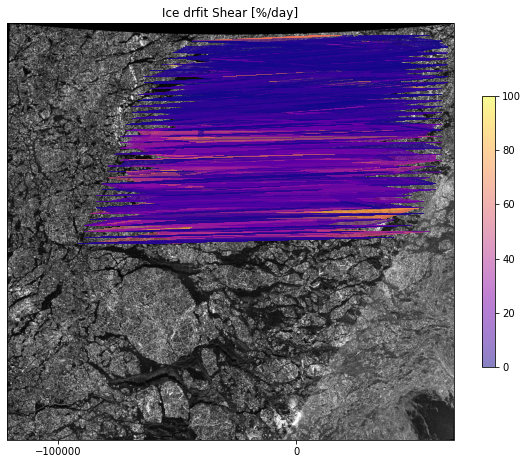

In [35]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
trp = plt.tripcolor(x1pm_er[gpi], y1pm_er[gpi], e2_er_1*24*60*60*100, triangles=t_er_1, vmin=0, vmax=100, cmap='plasma', mask=mask_er, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Shear [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

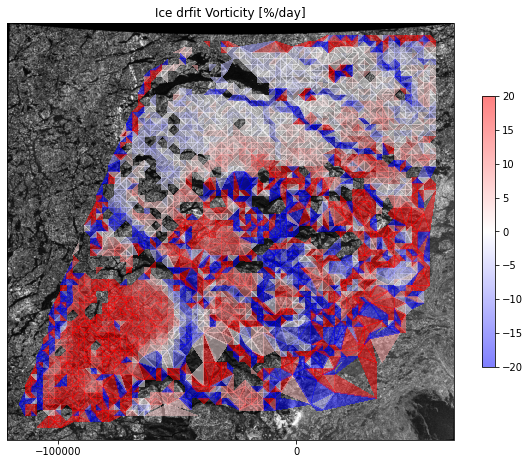

In [49]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
trp = plt.tripcolor(x1pm_er[gpi], y1pm_er[gpi], e3_er_1*24*60*60*100, triangles=t_er, vmin=-20, vmax=20, cmap='bwr', mask=mask_er, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Vorticity [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

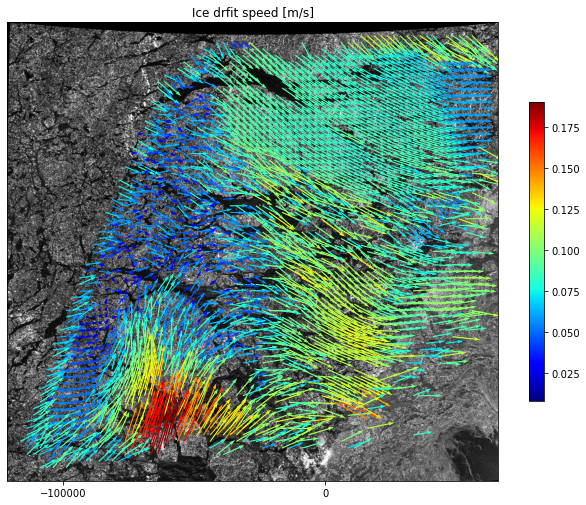

In [56]:
# compute ice drift speed [m/s]
delta_t = dayssec #in seconds
u_er_2 = upm_er_2 / delta_t
v_er_2 = vpm_er_2 / delta_t
speed_er_2 = np.sqrt((v_er_2**2+u_er_2**2)) 

# plot valid vectors in Polar stereographic projection
gpi_er = (hpm_er_2 > 7) 
# X/Y grids in polar stereographic projection covering image_1
x1pm_er, y1pm_er = dom_pm.get_geolocation_grids(dst_srs=srs)
#x1pm_er, y1pm_er = d.get_geolocation_grids(pm_step, dst_srs=srs)

# spacial reference for plotting
crs = ccrs.Mercator()

plt.figure(figsize=(11,11))
ax = plt.axes(projection=crs)


ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
quiv=ax.quiver(x1pm_er[gpi], y1pm_er[gpi], u_er_2[gpi], v_er_2[gpi],speed_er_2[gpi], scale=2, cmap='jet') #cmap='jet', width=0.008
plt.colorbar(quiv, shrink=0.5)
plt.quiverkey(quiv, 110000, -770000, 0.05, '0.05 m/s', coordinates='data')
plt.title('Ice drfit speed [m/s]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])


ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

In [52]:
# compute deformation components [1/s], area [m2], perimeter [m], triangulation
e1_er_2, e2_er_2, e3_er_2, a_er_2, p_er_2, t_er_2 = get_deformation_nodes(x1pm_er[gpi], y1pm_er[gpi], u_er_2[gpi], v_er_2[gpi])
# create mask for invalid elements (too squeezed or too large)
mask_er = (np.sqrt(a_er)/p_er < 0.15) + (a_er > 1e8)

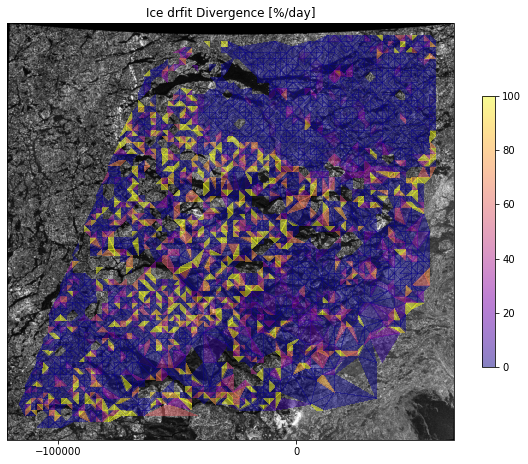

In [53]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
trp = plt.tripcolor(x1pm_er[gpi], y1pm_er[gpi], e1_er_2*24*60*60*100, triangles=t_er, vmin=0, vmax=100, cmap='plasma', mask=mask_er, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Divergence [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

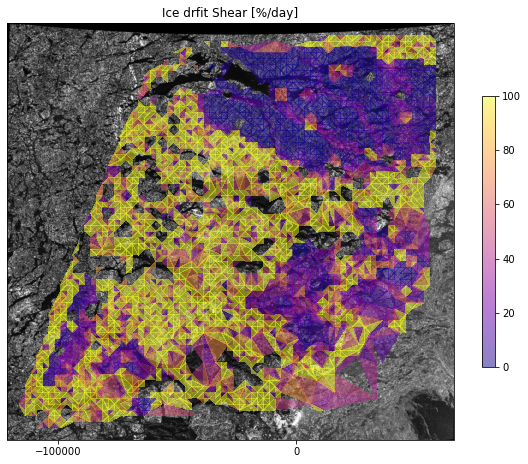

In [54]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
trp = plt.tripcolor(x1pm_er[gpi], y1pm_er[gpi], e2_er_2*24*60*60*100, triangles=t_er, vmin=0, vmax=100, cmap='plasma', mask=mask_er, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Shear [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

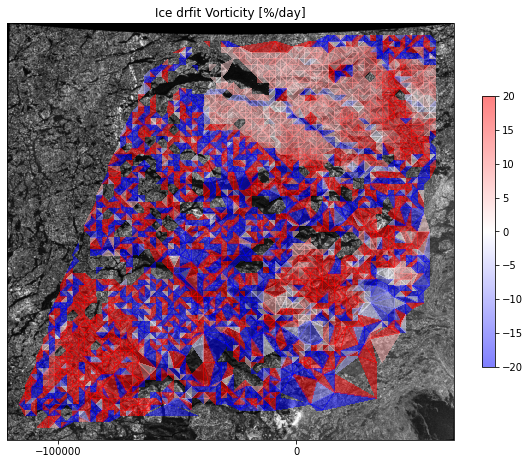

In [55]:
# plot deformation on top of the SAR image

plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

ax.imshow(a2, cmap='gray', extent=[x1pm_er.min(), x1pm_er.max(), y1pm_er.min(), y1pm_er.max()], origin='upper')
trp = plt.tripcolor(x1pm_er[gpi], y1pm_er[gpi], e3_er_2*24*60*60*100, triangles=t_er, vmin=-20, vmax=20, cmap='bwr', mask=mask_er, alpha=0.5)

plt.colorbar(trp, shrink=0.5)
plt.title('Ice drfit Vorticity [%/day]')
ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])

ax.set_xlim([x1pm_er.min(), x1pm_er.max()])
ax.set_ylim([y1pm_er.min(), y1pm_er.max()])
plt.show()

In [99]:
#EXPORTING DRIFT POINTS WITH ALL DATA IN WGS COORDINATE SYSTEM in degrees (v and u - displacement)

#Replace inf with nan. It seems that lat2, lon2 sometimes get inf and it effects u and v
#then it gives errors in alignment algortihm
infu = np.where(np.isinf(upm))
infv = np.where(np.isinf(vpm))
upm[infu] = np.nan
vpm[infv] = np.nan


lon1_flat, lat1_flat = lon1pm.flatten(),lat1pm.flatten()

u_flat, v_flat, a_flat, r_flat, h_flat = upm.flatten(), vpm.flatten(), apm.flatten(), rpm.flatten(), hpm.flatten()

In [103]:
points=zip(lon1_flat,lat1_flat, u_flat, v_flat, a_flat, r_flat, h_flat)
#points=zip(lon1_flat,lat1_flat, u_flat, v_flat)
header=['lon1','lat1','u','v', 'a','r', 'h']

with open('/home/jovyan/work/Icedrift/Special_curriculum/19-20_subset_experiment/algorithm_drift/S2-S2_prediction_drift2.csv','w') as f: 
    out = csv.writer(f, delimiter=',')
    out.writerow(header) 
    out.writerows(points)

In [58]:
#EXPORTING DATA TO 'DEFORMATION' NOTEBOOK, GETTING BACK RESULTS AND VISUALIZING DEFORMATION
%store upm
%store vpm
%store rpm
%store hpm
%store f1
%store f2
%store delta_t

Stored 'upm' (ndarray)
Stored 'vpm' (ndarray)
Stored 'rpm' (ndarray)
Stored 'hpm' (ndarray)
Stored 'f1' (NoneType)
Stored 'f2' (NoneType)
Stored 'delta_t' (int)


In [59]:
%store -r divergence_sr
%store -r convergence_sr
%store -r shear_sr
%store -r total_sr

%store -r divergence_dr
%store -r convergence_dr
%store -r shear_dr
%store -r total_dr

%store -r e_div_dr

%store -r divergence_n2
%store -r convergence_n2
%store -r shear_n2
%store -r total_n2

%store -r e_tot

In [62]:
mskt = (total_dr>5)
# filter mask
msk_total_dr  = mskt*1

# filter data arrays    
total_dr_msk = total_dr*mskt

# set no data to nan
total_dr_msk[mskt==0.0] = np.nan

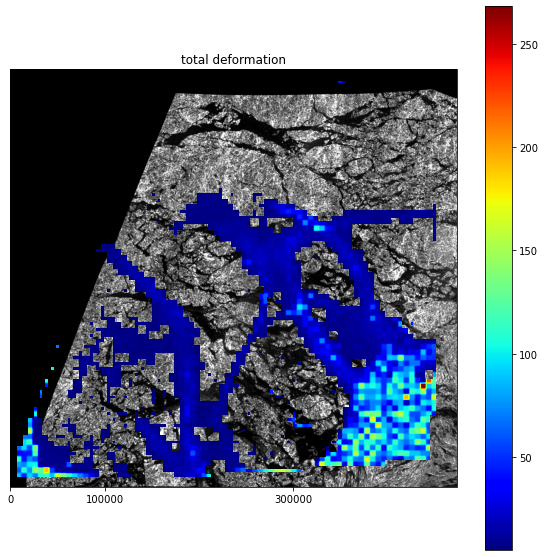

In [63]:
plt.figure(figsize=(10,10))
ax = plt.axes(projection=crs)

#(axes)  = plt.subplots(2,2, figsize=(30,30), sharex='all', sharey='all')
ax.imshow(a2, cmap='gray', extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper')
im=ax.imshow(total_dr_msk, extent=[x1pm.min(), x1pm.max(), y1pm.min(), y1pm.max()], origin='upper', cmap = 'jet') # for transparency  alpha = 0.3
plt.title('total deformation')
#divider = make_axes_locatable(axes[0][0])
#cax = divider.append_axes("right", size="5%", pad=0.05)
#clb1 = plt.colorbar(pm1, cax=cax)
#clb1.ax.set_xlabel(clb_txt)
#clb1.ax.tick_params(labelsize=FS-5)

ax.add_feature(land_50m, edgecolor='black')
ax.set_xticks([-300000, -100000, 0, 100000, 300000])
ax.set_yticks([-700000, -500000, -300000])
ax.set_xlim([x1pm.min(), x1pm.max()])
ax.set_ylim([y1pm.min(), y1pm.max()])
#plt.axes('off')
plt.colorbar(im)

    
    
plt.show()

